In [434]:
import csv
import json
import pandas as pd

import os

from anthropic import Anthropic

from inspect import cleandoc

from matplotlib import pyplot as plt

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

pd.set_option('display.max_colwidth', None)

# Claude AI and OpenCoesione data

blah blah

## Setups

In [266]:
client = Anthropic(api_key=os.environ['ANTHROPIC_KEY'])

In [267]:
model="claude-3-5-sonnet-20240620"

In [397]:
df = pd.read_csv('progetti_esteso_AMBIENTE_2014-2020_20240229.csv', sep=';')

/var/folders/38/x32ycmvj6zs1zqg8dn112ys40000gn/T/ipykernel_75662/2208063462.py:1: DtypeWarning: Columns (45,56,57,58,59,64,66,68,70,72,78,79,80,81,86,88,90,92,98,153) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('progetti_esteso_AMBIENTE_2014-2020_20240229.csv', sep=';')


In [323]:
len(df)
#df.columns[:20]

9134

## Clean

In [398]:
# prendi solo le colonne di titolo/descrizione 
df = df[['COD_LOCALE_PROGETTO', 'OC_TITOLO_PROGETTO']]

# rinomina 
df = df.rename(columns={'COD_LOCALE_PROGETTO': 'id', 'OC_TITOLO_PROGETTO': 'titolo'})

In [325]:
df.head(5)
df.dtypes

,id,titolo
0,11LA21038CA0341T0038,SENTIERISTICA DELLA FORESTA LAGO NEL PARCO DEI LUCRETILI
1,11LA22089CA0581T0001,PREVENZIONE INCENDI BOSCHIVI - FORNITURA E POSA DI VASCHE MOBILI AUTOPORTANTI CAPACITA' 6000 LITRI
2,11LA22090CA0582T0001,IMPLEMENTAZIONE STRUTTURALE DELLA RETE IRRIGUA DEL CONSORZIO DI BONIFICA ETRURIA MERIDIONALE E SABINA SUL PERIMETRO DELLA RISERVA NATURALE DI MONTE RUFENO PER LA PREVENZIONE INCENDI BOSCHIVI
3,11LA22090CA0582T0002,SELVA - RISORSE IDRICHE PER LA LOTTA ATTIVA
4,11LA22090CA0582T0003,SELVA - INFRASTRUTTURE PER LA LOTTA ATTIVA


id        object
titolo    object
dtype: object

In [322]:
DATASET = df.iloc[:].to_string()   # riduci per provare

In [324]:
len(DATASET), len(DATASET)/4

(5079059, 1269764.75)

In [275]:
len("fornitura idrica e gestione acque reflue")/4

8100/15

10.0

540.0

## Prompt

In [276]:
# system_prompt = """
# Sei un esperto nella classificazione di stringhe di testo. 
# """

# prompt = f"""
# Ti passo un CSV. I dati riguardano progetti di sviluppo territoriale a tema ambiente, 
# finanziati dal governo italiano, la colonna 'id' è un identificativo e la colonna 'titolo' il titolo del progetto.
# Identifica l'ambito di ogni progetto dal suo titolo, classificandolo in gruppi: 
# esempi di ambito sono energia, spazi verdi, riqualificazione urbana, riduzione emissioni, 
# messa in sicurezza, dissesto idrogeologico etc.

# Questo è il contenuto del CSV: <dataset>{DATASET}</dataset>. 

# Fornisci il risultato seguendo questo **schema JSON** {AmbitoProgetto.model_json_schema()} senza nient'altro.
# """

In [277]:
prompt = f"""
Ti passo un CSV. I dati riguardano progetti di sviluppo territoriale a tema ambiente, 
finanziati dal governo italiano, la colonna 'id' è un identificativo e la colonna 'titolo' il titolo del progetto.
Identifica l'ambito di ogni progetto dal suo titolo, classificandolo in gruppi: 
esempi di ambito sono energia, spazi verdi, riqualificazione urbana, riduzione emissioni, 
messa in sicurezza, dissesto idrogeologico etc.

Questo è il contenuto del CSV: <dataset>{DATASET}</dataset>. 

Fornisci il risultato sotto forma di lista Python in cui ogni entrata è un dizionario con campi "id" e "ambito"
e non dire altro.
"""

In [251]:
#prompt

In [252]:
response = client.messages.create(
    model="claude-3-5-sonnet-20240620",
    max_tokens=8100,   # near the max allowed
    temperature=0,
    system=cleandoc(system_prompt),
    messages=[
        {"role": "user", "content": cleandoc(prompt)},
        # {"role": "assistant", "content": "{" }
    ]
)

## Results

In [253]:
response.content[0].text

'[\n    {"id": "1AGCOE2019", "ambito": "gestione rifiuti"},\n    {"id": "1AGCOE2020", "ambito": "riduzione inquinamento acustico"},\n    {"id": "1AGCOE2021", "ambito": "riduzione inquinamento acustico"},\n    {"id": "1AGCOE2022", "ambito": "gestione rifiuti"},\n    {"id": "1AGCOE2024", "ambito": "energia rinnovabile"},\n    {"id": "1AGCOE2069", "ambito": "gestione rifiuti"},\n    {"id": "1AGCOE2070", "ambito": "gestione rifiuti"},\n    {"id": "1AGCOE2071", "ambito": "gestione rifiuti"},\n    {"id": "1AGCOE2075", "ambito": "riqualificazione urbana"},\n    {"id": "1AGCOE2076", "ambito": "forestazione urbana"},\n    {"id": "1AGCOE2077", "ambito": "forestazione urbana"},\n    {"id": "1AGCOE2078", "ambito": "forestazione urbana"},\n    {"id": "1AGCOE2079", "ambito": "gestione rifiuti"},\n    {"id": "1AGCOE2080", "ambito": "forestazione urbana"},\n    {"id": "1AGCOE2081", "ambito": "bonifica ambientale"},\n    {"id": "1AGCOE2082", "ambito": "spazi verdi"},\n    {"id": "1AGCOE2083", "ambito":

In [254]:
d = json.loads(response.content[0].text)

In [255]:
json.dump(d, open('claude_resp_400_700.json', 'w'))

## Systematise in a for loop

In [378]:
i = 0
step = 125

while i < len(df):
    print(i)
    
    DATASET = df.iloc[i:i+step].to_string()
    
    system_prompt = """Sei un esperto nella classificazione di stringhe di testo."""
    
    prompt = f"""
        Ti passo un CSV. I dati riguardano progetti di sviluppo territoriale a tema ambiente, 
        finanziati dal governo italiano, la colonna 'id' è un identificativo e la colonna 'titolo' il titolo del progetto.
        Identifica l'ambito di ogni progetto dal suo titolo, classificandolo in gruppi: 
        esempi di ambito sono energia, spazi verdi, riqualificazione urbana, riduzione emissioni, 
        messa in sicurezza, dissesto idrogeologico etc.

        Questo è il contenuto del CSV: <dataset>{DATASET}</dataset>. 

        Fornisci il risultato sotto forma di lista Python in cui ogni entrata è un dizionario con campi "id" e "ambito"
        (usa sempre virgolette doppie) e non dire altro.
        """
    
    response = client.messages.create(
        model="claude-3-5-sonnet-20240620",
        max_tokens=2000,  
        temperature=0,
        system=cleandoc(system_prompt),
        messages=[
            {"role": "user", "content": cleandoc(prompt)},
        ]
    )
    d = json.loads(response.content[0].text)
    
    json.dump(d, open(f'claude_resp_{i}_{i+step}.json', 'w'))
    
    i += step

0


## read all produced data into a df

In [333]:
df_claude = pd.DataFrame()

for filename in os.listdir('claude_ambito/'):
    if '.json' in filename:
        d = json.load(open('claude_ambito/' + filename, 'r'))
        print(filename, len(d))
        
        df_claude = pd.concat([df_claude, pd.DataFrame(d)])
        

claude_resp_7940_8000.json 60
claude_resp_6980_7040.json 60
claude_resp_600_900.json 300
claude_resp_7700_7760.json 60
claude_resp_1750_2000.json 250
claude_resp_8600_8660.json 60
claude_resp_6740_6800.json 60
claude_resp_5750_6000.json 250
claude_resp_1500_1750.json 250
claude_resp_6250_6500.json 250
claude_resp_7640_7700.json 60
claude_resp_2250_2500.json 250
claude_resp_5500_5750.json 250
claude_resp_7100_7160.json 60
claude_resp_8000_8060.json 60
claude_resp_4500_4750.json 250
claude_resp_3250_3500.json 250
claude_resp_900_1200.json 300
claude_resp_7040_7100.json 60
claude_resp_6920_6980.json 60
claude_resp_7580_7640.json 60
claude_resp_7280_7340.json 60
claude_resp_7220_7280.json 60
claude_resp_8060_8120.json 60
claude_resp_4750_5000.json 250
claude_resp_8660_8720.json 60
claude_resp_0_300.json 300
claude_resp_7760_7820.json 60
claude_resp_3000_3250.json 250
claude_resp_3750_4000.json 250
claude_resp_2000_2250.json 250
claude_resp_8480_8540.json 60
claude_resp_6000_6250.json 250
c

## Looking at missing ones

In [331]:
len(df_claude)

9009

In [334]:
df[df['id']=='4BA23/2017/0899']

,id,titolo
5249,4BA23/2017/0899,COMPLETAMENTO DELLA MAPPATURA DEGLI HABITAT DELLE ZSC VERSANTE LUCANO DEL PNP


In [342]:
d = json.load(open('claude_ambito/claude_resp_5000_5250.json'))

df_tmp = pd.DataFrame(d)

In [344]:
len(df_tmp)
df_tmp

125

,id,ambito
0,35EMADRION1321//10005,energia rinnovabile
1,35EMADRION205//594,gestione costiera
2,35EMADRION340//1280,monitoraggio ambientale
3,35EMADRION450//1760,protezione ecosistemi
4,35EMADRION69//1008,gestione rischi naturali
...,...,...
120,4BA23/2017/0889,turismo sostenibile
121,4BA23/2017/0890,conservazione fauna
122,4BA23/2017/0893,conservazione forestale
123,4BA23/2017/0894,conservazione habitat


In [348]:
df_cut = df.iloc[5000:5250]

In [352]:
# quelli mancanti - index 

df_merge= df_cut.merge(df_tmp, on='id', how='left')

In [364]:
len(df_merge[df_merge.ambito.isna()])

missing_ids = list(df_merge[df_merge.ambito.isna()]['id'])

len(missing_ids)

missing_ids[:5]

125

125

['35EMADRION1321//9961',
 '35EMADRION1321//9964',
 '35EMADRION1321//9966',
 '35EMADRION1321//9968',
 '35EMADRION1321//9969']

In [371]:
df_missing = df_cut[df_cut['id'].isin(missing_ids)]

## Join with the original 

In [413]:
# reread the original as it has the description cols
df = pd.read_csv('progetti_esteso_AMBIENTE_2014-2020_20240229.csv', sep=';')

# renames
df = df.rename(columns={'COD_LOCALE_PROGETTO': 'id', 'OC_TITOLO_PROGETTO': 'titolo'})

/var/folders/38/x32ycmvj6zs1zqg8dn112ys40000gn/T/ipykernel_75662/4207547687.py:2: DtypeWarning: Columns (45,56,57,58,59,64,66,68,70,72,78,79,80,81,86,88,90,92,98,153) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('progetti_esteso_AMBIENTE_2014-2020_20240229.csv', sep=';')


In [414]:
df = df.merge(df_claude, on='id', how='left')  # you may want to reread the original before this, and rename id col

In [416]:
# take the description cols plus title and id and new col
df = df[['id', 'titolo']+[col for col in df.columns if 'DESCR' in col] + ['ambito']]

In [419]:
# remove some useless ones actually 
del df['OC_DESCR_CICLO']

In [422]:
# df.groupby('DESCR_INDICATORE_1').count()

In [423]:
df

,id,titolo,DESCRIZIONE_GRANDE_PROGETTO,OC_DESCRIZIONE_PROGRAMMA,DESCR_OB_TEMATICO,DESCR_PRIORITA_INVEST,OC_DESCR_CATEGORIA_SPESA,OC_DESCR_ARTICOLAZ_PROGRAMMA,OC_DESCR_SUBARTICOLAZ_PROGRAMMA,DESCR_STRUMENTO,...,DESCR_TIPO_PROCED_ATTIVAZIONE,OC_DESCR_FORMA_GIU_PROGRAMMATORE,OC_DESCR_FORMA_GIU_ATTUATORE,OC_DESCR_FORMA_GIU_BENEFICIARIO,OC_DESCR_FORMA_GIU_REALIZZATORE,DESCR_INDICATORE_1,DESCR_INDICATORE_2,DESCR_INDICATORE_3,DESCR_INDICATORE_4,ambito
0,11LA21038CA0341T0038,SENTIERISTICA DELLA FORESTA LAGO NEL PARCO DEI LUCRETILI,,PSC LAZIO,,,"Investimenti produttivi generici nelle piccole e medie imprese (""PMI""):::Sviluppo e promozione del potenziale turistico delle aree naturali",Competitivita' Imprese,Turismo e ospitalita',APQ aree interne LAZIO - Monti Simbruini,...,Procedura negoziale,Regione,,Comunita' montana o isolana,,Numero di azioni/progetti finanziati,,,,spazi verdi
1,11LA22089CA0581T0001,PREVENZIONE INCENDI BOSCHIVI - FORNITURA E POSA DI VASCHE MOBILI AUTOPORTANTI CAPACITA' 6000 LITRI,,STRATEGIA AREE INTERNE REGIONE LAZIO SERVIZI,,,"Misure di adattamento ai cambiamenti climatici, prevenzione e gestione dei rischi connessi al clima, quali erosione, incendi, inondazioni, tempeste e siccitÃ , comprese azioni di sensibilizzazione, protezione civile nonchÃ© sistemi e infrastrutture per la gestione delle catastrofi",Area Interna Valle di Comino_DL 120_2021,Prevenzione e Contrasto Incendi Boschivi,APQ aree interne LAZIO - VALLE DEL COMINO,...,Procedura negoziale,Regione,Regione,Regione,,Beneficiari/Popolazione Beneficiaria,,,,prevenzione incendi
2,11LA22090CA0582T0001,IMPLEMENTAZIONE STRUTTURALE DELLA RETE IRRIGUA DEL CONSORZIO DI BONIFICA ETRURIA MERIDIONALE E SABINA SUL PERIMETRO DELLA RISERVA NATURALE DI MONTE RUFENO PER LA PREVENZIONE INCENDI BOSCHIVI,,STRATEGIA AREE INTERNE REGIONE LAZIO SERVIZI,,,"Misure di adattamento ai cambiamenti climatici, prevenzione e gestione dei rischi connessi al clima, quali erosione, incendi, inondazioni, tempeste e siccitÃ , comprese azioni di sensibilizzazione, protezione civile nonchÃ© sistemi e infrastrutture per la gestione delle catastrofi",Area Interna Alta Tuscia_DL 120_2021,Prevenzione e Contrasto Incendi Boschivi,APQ aree interne LAZIO - Alta Tuscia,...,Procedura negoziale,Regione,Consorzio di diritto pubblico,Consorzio di diritto pubblico,,Beneficiari/Popolazione Beneficiaria,,,,prevenzione incendi
3,11LA22090CA0582T0002,SELVA - RISORSE IDRICHE PER LA LOTTA ATTIVA,,STRATEGIA AREE INTERNE REGIONE LAZIO SERVIZI,,,"Misure di adattamento ai cambiamenti climatici, prevenzione e gestione dei rischi connessi al clima, quali erosione, incendi, inondazioni, tempeste e siccitÃ , comprese azioni di sensibilizzazione, protezione civile nonchÃ© sistemi e infrastrutture per la gestione delle catastrofi",Area Interna Alta Tuscia_DL 120_2021,Prevenzione e Contrasto Incendi Boschivi,APQ aree interne LAZIO - Alta Tuscia,...,Procedura negoziale,Regione,Comune,Comune,,Beneficiari/Popolazione Beneficiaria,,,,gestione risorse idriche
4,11LA22090CA0582T0003,SELVA - INFRASTRUTTURE PER LA LOTTA ATTIVA,,STRATEGIA AREE INTERNE REGIONE LAZIO SERVIZI,,,"Misure di adattamento ai cambiamenti climatici, prevenzione e gestione dei rischi connessi al clima, quali erosione, incendi, inondazioni, tempeste e siccitÃ , comprese azioni di sensibilizzazione, protezione civile nonchÃ© sistemi e infrastrutture per la gestione delle catastrofi",Area Interna Alta Tuscia_DL 120_2021,Prevenzione e Contrasto Incendi Boschivi,APQ aree interne LAZIO - Alta Tuscia,...,Procedura negoziale,Regione,Comune,Comune,,Beneficiari/Popolazione Beneficiaria,,,,prevenzione incendi
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9129,9UM8432289,"INTERVENTI IN SOMMA URGENZA PER LA MESSA IN SICUREZZA DEL CAMPANILE, DELLE PORZIONI DI MURATURA SU VIA MAZZINI E COMPLETAMENTO DELLA RIMOZIONE DELLE MACERIE DELLA BASILICA DI SAN BENEDETTO.",,POR FESR UMBRIA,"Promuovere l'adattamento al cambiamento climatico, la

In [432]:
len(set(df['ambito']))
df.groupby('ambito').count()['id'].sort_values(ascending=False)

706

ambito
messa in sicurezza                       609
dissesto idrogeologico                   602
gestione rifiuti                         584
riqualificazione urbana                  324
gestione acque                           265
                                        ... 
declassamento infrastrutture               1
protezione acque                           1
delocalizzazione impianto depurazione      1
depurazione e fognature                    1
minimizzazione rischio idrogeologico       1
Name: id, Length: 705, dtype: int64

In [453]:
set(df['ambito'])

{'abbattimento barriere architettoniche',
 'accessibilità',
 'accessibilità forestale',
 'accessibilità foreste',
 'acquedotti',
 'adattamento climatico',
 'adeguamento antisismico',
 'adeguamento collettore',
 'adeguamento cunetta e opere di difesa',
 'adeguamento depuratore',
 'adeguamento difese di sponda',
 'adeguamento idraulico',
 'adeguamento impianti',
 'adeguamento impianti depurazione',
 'adeguamento impianti depurazione e rete fognaria',
 'adeguamento impianti irrigui',
 'adeguamento impianti potabilizzazione',
 'adeguamento impianto depurazione',
 'adeguamento impianto depurazione e rete fognaria',
 'adeguamento infrastrutture',
 'adeguamento opere idriche',
 'adeguamento rete fognaria',
 'adeguamento rete fognaria e idrica',
 'adeguamento rete fognaria e impianti depurazione',
 'adeguamento rete fognaria e impianto depurazione',
 'adeguamento rete idraulica',
 'adeguamento rete idrica',
 'adeguamento sezioni di deflusso',
 'adeguamento sismico',
 'adeguamento statico',
 'a

<Figure size 1080x432 with 0 Axes>

(array([0. , 0.2, 0.4, 0.6, 0.8, 1. ]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

Text(0.5, 1.0, 'Projects per category - top 100')

Text(0, 0.5, '#\xa0projects')

<BarContainer object of 100 artists>

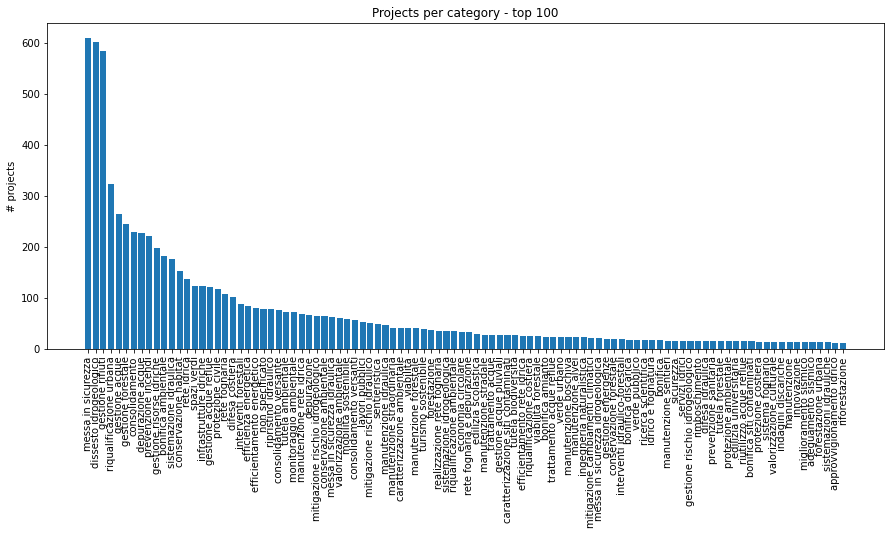

In [452]:
df_tmp = df.groupby('ambito').count()['id'].sort_values(ascending=False).reset_index()

plt.figure(figsize=(15, 6))

plt.xticks(rotation=90);
plt.title('Projects per category - top 100');
plt.ylabel('# projects');

plt.bar(df_tmp['ambito'].iloc[:100], df_tmp['id'].iloc[:100]);

plt.savefig('proj_cats.jpeg')

In [429]:
df.to_csv('claude_results.csv', index=False)

In [430]:
df_missing

,id,titolo
5001,35EMADRION1321//9961,ADRION TRANSNATIONAL MASTER IN RENEWABLE ENERGY
5002,35EMADRION1321//9964,ADRION TRANSNATIONAL MASTER IN RENEWABLE ENERGY
5003,35EMADRION1321//9966,ADRION TRANSNATIONAL MASTER IN RENEWABLE ENERGY
5004,35EMADRION1321//9968,ADRION TRANSNATIONAL MASTER IN RENEWABLE ENERGY
5005,35EMADRION1321//9969,ADRION TRANSNATIONAL MASTER IN RENEWABLE ENERGY
...,...,...
5142,3PIPBAN-SNAI25349,(A19_2022_02_04_UM_VALLE_MAIRA) INTERVENTI DI RIDUZIONE DELL'INFIAMMABILITÃ DELLA VEGETAZIONE_AI_VALLI MAIRA E GRANA
5143,3PIPBAN-SNAI25350,(A19_2022_03_01_UMVO) INTERVENTI RIPRISTINO E INTEGRAZIONE PUNTI ACQUA ACQUISTO MEZZI D'OPERA PER L'AMPLIAMENTO LORO EFFICACIA E FUNZIONALITÃ _AI_VALLI OSSOLA
5144,3PIPBAN-SNAI25351,(A19_2022_03_04_UM_VALLE_MAIRA) INTERVENTI MANUTENZIONE E INTEGRAZIONE PUNTI ACQUA_AI_MAIRA E GRANA
5145,3PIPBAN-SNAI25352,(A19_2022_03_03_UM_ALTALANGA) INTERVENTI RIFUNZIONALIZZAZIONE E INTEGRAZIONE PUNTI ACQUA ACQUISTO MEZZI D'OPERA PER L'AMPLIAMENTO LORO EFFICACIA E FUNZIONALITÃ _AI_VALLE BORMIDA
